In [6]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.4.1
Eager execution: True


In [7]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

#train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
#                                          origin=train_dataset_url)
train_dataset_fp = "/home/paul/dev/intelligent_learn/data/train.csv"
print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: /home/paul/dev/intelligent_learn/data/train.csv


In [8]:
# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']


Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


In [9]:
batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)
print(train_dataset.shape)

AttributeError: 'PrefetchDataset' object has no attribute 'shape'

In [10]:
features, labels = next(iter(train_dataset))


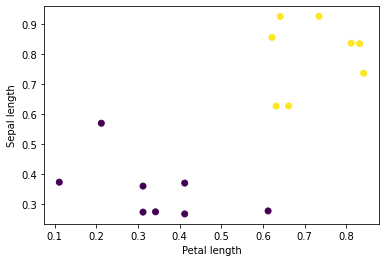

In [11]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

In [12]:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

In [13]:
train_dataset = train_dataset.map(pack_features_vector)
features, labels = next(iter(train_dataset))
#print(train_dataset)

In [14]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  #tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

In [15]:
print(features)
predictions = model(features)
print(predictions)

tf.Tensor(
[[0.8373    0.6816    0.81112   0.9223   ]
 [0.737     0.624     0.8412    0.5323   ]
 [0.274     0.47      0.342     0.33123  ]
 [0.857     0.68115   0.6212    0.8123   ]
 [0.9274    0.847     0.7342    0.6633123]
 [0.57      0.115     0.212     0.123    ]
 [0.267     0.137     0.412     0.2323   ]
 [0.6273    0.98476   0.6312    0.6223   ]
 [0.373     0.16      0.1112    0.223    ]
 [0.836     0.9437    0.8312    0.681223 ]
 [0.9267    0.8137    0.6412    0.82323  ]
 [0.277     0.14      0.612     0.323    ]
 [0.273     0.476     0.312     0.223    ]
 [0.37      0.24      0.412     0.323    ]
 [0.36      0.437     0.312     0.1223   ]
 [0.6277    0.714     0.6612    0.8323   ]], shape=(16, 4), dtype=float32)
tf.Tensor(
[[ 1.1208105   0.7542406  -0.70457584]
 [ 0.8012574   0.61631966 -0.4988514 ]
 [ 0.4643574   0.16691351 -0.27278745]
 [ 1.0172127   0.66648054 -0.6357366 ]
 [ 0.9772919   0.6287073  -0.59844357]
 [ 0.25428152  0.44407302 -0.23357335]
 [ 0.31009716  0.3149553

In [16]:
loss_object = tf.keras.losses.MeanSquaredError()
import numpy as np
import random

#mask = np.array(labels.map_fn(lambda label: label == 1))

#print(mask)
#other_results = tf.boolean_mask(labels,mask)
#print(other_results)

def get_new_y(predictions, labels):
  new_y = []
  for idx, val in enumerate(predictions.numpy()):
      label = labels[idx].numpy()
      relevant_data = []
      for idx2, value in enumerate(labels.numpy()):
          if(value == label and idx2 != idx):
              relevant_data.append(predictions[idx2])
      new_y.append(relevant_data[random.randint(0,len(relevant_data)-1)])
  return new_y

def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)
  #print(x)
  new_y = get_new_y(y_, y)

  return loss_object(y_true=new_y, y_pred=y_)


l = loss(model, features, labels, training=False)
print("Loss test: {}".format(l))

Loss test: 0.015156036242842674


In [17]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [18]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)


In [19]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels, training=True).numpy()))

Step: 0, Initial Loss: 0.017227251082658768
Step: 1,         Loss: 0.016855113208293915


In [20]:
## Note: Rerunning this cell uses the same model variables

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []
num_epochs = 1501

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.MeanAbsoluteError()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(x, training=True)
    new_y = get_new_y(predictions, y)
    epoch_accuracy.update_state(new_y, predictions)

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, MAE: {:.3}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 0.018, MAE: 0.0905
Epoch 050: Loss: 0.017, MAE: 0.0928
Epoch 100: Loss: 0.013, MAE: 0.0924
Epoch 150: Loss: 0.011, MAE: 0.0968
Epoch 200: Loss: 0.013, MAE: 0.0845
Epoch 250: Loss: 0.011, MAE: 0.0954
Epoch 300: Loss: 0.012, MAE: 0.0647
Epoch 350: Loss: 0.012, MAE: 0.0665
Epoch 400: Loss: 0.010, MAE: 0.0635
Epoch 450: Loss: 0.010, MAE: 0.0763
Epoch 500: Loss: 0.006, MAE: 0.0696
Epoch 550: Loss: 0.009, MAE: 0.0685
Epoch 600: Loss: 0.006, MAE: 0.0629
Epoch 650: Loss: 0.007, MAE: 0.0749
Epoch 700: Loss: 0.007, MAE: 0.063
Epoch 750: Loss: 0.006, MAE: 0.0683
Epoch 800: Loss: 0.006, MAE: 0.0665
Epoch 850: Loss: 0.005, MAE: 0.0618
Epoch 900: Loss: 0.005, MAE: 0.0553
Epoch 950: Loss: 0.004, MAE: 0.0456
Epoch 1000: Loss: 0.004, MAE: 0.0488
Epoch 1050: Loss: 0.005, MAE: 0.0617
Epoch 1100: Loss: 0.004, MAE: 0.0462
Epoch 1150: Loss: 0.003, MAE: 0.0452
Epoch 1200: Loss: 0.006, MAE: 0.0608
Epoch 1250: Loss: 0.004, MAE: 0.0552
Epoch 1300: Loss: 0.004, MAE: 0.0596
Epoch 1350: Loss: 0.00

In [21]:
 a = [0.177, 0.24, 0.512, 0.423]
 b = [0.9277, 0.614, 0.5612, 0.9323]
 c = [0.142, 0.423, 0.223, 0.312]
 d = [0.846, 0.947, 0.542, 0.657]
 results = model(tf.constant([a,b,c,d]), training=False).numpy()
 print(results)
 print(np.linalg.norm(results[0]-results[2]))
 print(np.linalg.norm(results[1]-results[3]))

 print(np.linalg.norm(results[0]-results[3]))
 print(np.linalg.norm(results[1]-results[2]))

[[ 0.28591654  0.20274727 -0.19525181]
 [ 0.7021659   0.4857812  -0.40036255]
 [ 0.22559318  0.2053052  -0.14340849]
 [ 0.5975208   0.46692458 -0.31813243]]
0.07958128
0.1344171
0.42659882
0.6097653
